## UAS Pengolahan Citra
## Nama: David Jonathan Tjong
## NIM : 2211016310007

## Input Gambar

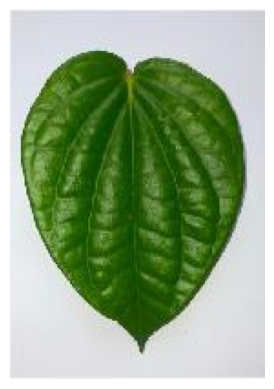

In [ ]:
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# Membaca dan menampilkan gambar
image_path = "gambar-daun.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()


## Mengubah citra ke hsv

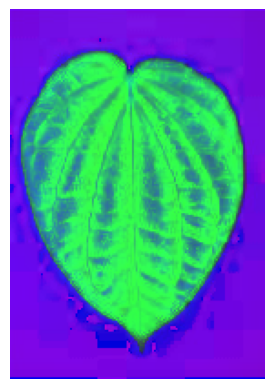

In [ ]:
# rgb to hsv
image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

plt.imshow(image_hsv)
plt.axis('off')
plt.show()

## Segmentasi

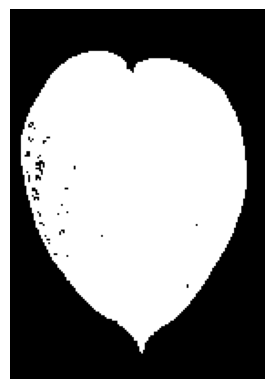

In [ ]:
# Melakukan segmentasi tresholding dengan mendaptkan ambang batas optimal melalui otsu tresholding
# Convert to grayscale
graycale_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply threshold to create binary image
ambang_batas_optimal, binary_image = cv2.threshold(graycale_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()


## Morfologi

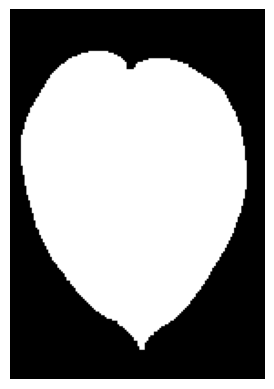

In [ ]:
import numpy as np

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# 1. Filling Holes: Menggunakan operasi dilasi untuk mengisi lubang
flood_fill = binary_image.copy()
h, w = binary_image.shape
mask = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)

flood_fill_inv = cv2.bitwise_not(flood_fill)  # Membalik warna flood fill
filled_image = binary_image | flood_fill_inv  # Gabungkan untuk mengisi lubang

# 2. Opening: Menghapus noise kecil di luar objek (erosi diikuti dilasi)
opening_image = cv2.morphologyEx(filled_image, cv2.MORPH_OPEN, kernel)

# 3. Closing: Menutup celah kecil atau lubang kecil di dalam objek (dilasi diikuti erosi)
closing_image = cv2.morphologyEx(opening_image, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing_image, cmap='gray')
plt.axis('off')
plt.show()


## Memasking gambar


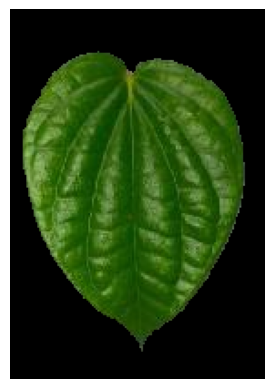

In [ ]:
# ----- Segmentasi dengan Watershed -----

# Sure background (dilasi gambar hasil closing)
sure_bg = cv2.dilate(closing_image, kernel, iterations=2)

# Sure foreground (menggunakan Distance Transform)
dist_transform = cv2.distanceTransform(closing_image, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Tambahkan satu agar latar belakang bukan 0
markers = markers + 1

# Tandai region unknown dengan 0
markers[unknown == 255] = 0

# Terapkan algoritma Watershed
image_asli = cv2.imread("gambar-daun.jpg")
markers = cv2.watershed(image_asli, markers)

# Mask untuk objek yang tersegmentasi
object_mask = np.zeros_like(markers, dtype=np.uint8)
object_mask[markers > 1] = 255  # Ambil hanya area objek (markers > 1)

# Proses masking
image_rgb = cv2.cvtColor(image_asli, cv2.COLOR_BGR2RGB)
segmented_object = cv2.bitwise_and(image_rgb, image_rgb, mask=object_mask)

# Proses masking
# segmented_object = cv2.bitwise_and(image_asli, image_asli, mask=object_mask)

plt.imshow(segmented_object, cmap='gray')
plt.axis('off')
plt.show()

## Kompresi Gambar

Dimensi gambar awal: (203, 140, 3)
PSNR: 4.28 dB
SSIM: 0.4059


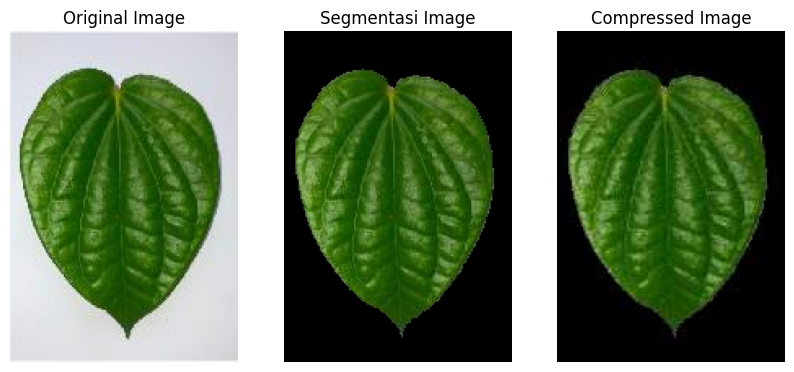

Compressed image saved to output1_compressed.jpg
Ukuran image asli : 8.10 KB
Ukuran image output : 3.41 KB


In [ ]:
from skimage.metrics import structural_similarity as ssim
import os

def compress_image(image, output_path, quality=50):
    # konversi ruang warna
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Dimensi gambar awal:", img.shape)
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # ekstraksi komponen
    cr = img_YCrCb[:, :, 1]
    cb = img_YCrCb[:, :, 2]
    target_shape = (cr.shape[1] // 2, cr.shape[0] // 2)

    # resizing
    cr_resized = cv2.resize(cr, target_shape, interpolation=cv2.INTER_LINEAR)
    cb_resized = cv2.resize(cb, target_shape, interpolation=cv2.INTER_LINEAR)

    # rekonstruksi
    img_YCrCb[:, :, 1] = cv2.resize(cr_resized, img_YCrCb[:, :, 0].shape[::-1])
    img_YCrCb[:, :, 2] = cv2.resize(cb_resized, img_YCrCb[:, :, 0].shape[::-1])

    # konversi kembali ke BGR
    img_compressed = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2BGR)

    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, img_compressed = cv2.imencode('.jpg',img_compressed, encode_param)

    with open(output_path, 'wb') as f:
        f.write(img_compressed)

def evaluate_metrics(original_image, compressed_image):
    original = cv2.imread(original_image)
    compressed = cv2.imread(compressed_image)
    psnr_value = cv2.PSNR(original, compressed)
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed, cv2.COLOR_BGR2GRAY)
    ssim_value = ssim(original_gray, compressed_gray)
    return psnr_value, ssim_value

input_path = "./gambar-daun.jpg"
output_path = "output1_compressed.jpg"
compress_image(segmented_object, output_path)
psnr, ssim_val = evaluate_metrics(input_path, output_path)
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Segmentasi Image")
plt.imshow(segmented_object)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Compressed Image")
image_out = cv2.imread(output_path)
image_out = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
plt.imshow(image_out)
plt.axis("off")

plt.show()

print(f"Compressed image saved to {output_path}")
print(f"Ukuran image asli : {((os.path.getsize(input_path))/1024):.2f} KB")
print(f"Ukuran image output : {((os.path.getsize(output_path))/1024):.2f} KB")
